# How to manage state in subgraphs

For more complex systems, sub-graphs are a useful design principle. Sub-graphs allow you to create and manage different states in different parts of your graph. This allows you build things like [multi-agent teams](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/), where each team can track its own separate state.

In this how-to guide we will cover how to manage the persisted state in subgraphs. This will enable a lot of the human-in-the-loop interaction patterns.

## Setup

First we need to install the packages required

In [3]:
%%capture --no-stderr
%pip install -U langgraph

Next, we need to set API keys for OpenAI (the LLM we will use):

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")

## Define SubGraph

First, let's set up our subgraph. For this, we will create a simple graph that can get the weather for a specific city. We will compile this graph with a [breakpoint](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/)before the `weather_node`:

In [30]:
from langgraph.graph import StateGraph, END, START, MessagesState
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI


@tool
def get_weather(city: str):
    """Get the weather for a specific city"""
    return f"It's sunny in {city}!"

raw_model = ChatOpenAI()
model = raw_model.with_structured_output(get_weather)


class SubGraphState(MessagesState):
    city: str


def model_node(state: SubGraphState):
    result = model.invoke(state['messages'])
    return {"city": result["city"]}

def weather_node(state: SubGraphState):
    result = get_weather.invoke({"city": state['city']})
    return {"messages": [{"role": "assistant", "content": result}]}


subgraph = StateGraph(SubGraphState)
subgraph.add_node(model_node)
subgraph.add_node(weather_node)
subgraph.add_edge(START, "model_node")
subgraph.add_edge("model_node", "weather_node")
subgraph.add_edge("weather_node", END)
subgraph = subgraph.compile(interrupt_before=["weather_node"])

## Define Parent Graph

We can now setup the overall graph. This graph will first route to the subgraph if it needs to get the weather, otherwise it will route to a normal LLM.

In [31]:
from typing import TypedDict, Literal
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


class RouterState(MessagesState):
    route: Literal["weather", "other"]


class Router(TypedDict):
    route: Literal["weather", "other"]

router_model = raw_model.with_structured_output(Router)
    
def router_node(state: RouterState):
    system_message = "Classify the incoming query as either about weather or not."
    messages = [{"role": "system", "content": system_message}] + state['messages']
    route = router_model.invoke(messages)
    return {"route": route['route']}


def normal_llm_node(state: RouterState):
    response = raw_model.invoke(state['messages'])
    return {"messages": [response]}


def route_after_prediction(state: RouterState) -> Literal["weather_graph", "normal_llm_node"]:
    if state['route'] == "weather":
        return "weather_graph"
    else:
        return "normal_llm_node"


graph = StateGraph(RouterState)
graph.add_node(router_node)
graph.add_node(normal_llm_node)
graph.add_node("weather_graph", subgraph)
graph.add_edge(START, "router_node")
graph.add_conditional_edges("router_node", route_after_prediction)
graph.add_edge("normal_llm_node", END)
graph.add_edge("weather_graph", END)
graph = graph.compile(checkpointer=memory)

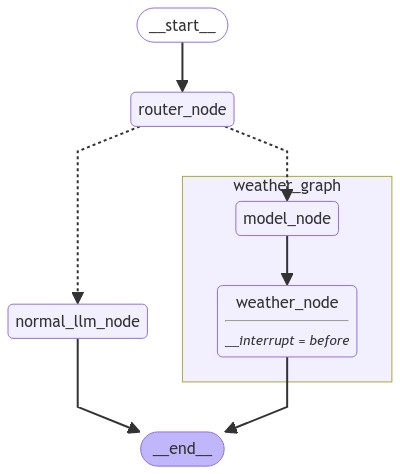

In [32]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's test this out with a normal query to make sure it works as intended!

In [33]:
config = {"configurable": {"thread_id": "1"}}
inputs = {"messages": [{"role": "user", "content": "hi!"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'other'}}
{'normal_llm_node': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-9730e690-8cbd-4ba0-a962-3f8a4e848ef9-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18})]}}


Great! We didn't ask about the weather, so we got a normal response from the LLM.

## Resuming from breakpoints

Let's now look at what happens with breakpoints. Let's invoke it with a query that should get routed to the weather subgraph where we have the interrupt node.

In [34]:
config = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'weather'}}


Note that the graph stream doesn't include subgraph events. If we want to stream subgraph events, we can pass `subgraphs=True` and get back subgraph events like so:

In [35]:
config = {"configurable": {"thread_id": "3"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="values", subgraphs=True):
    print(update)

((), {'messages': [HumanMessage(content="what's the weather in sf", id='ad42a2dc-57c5-4aae-b616-6a86ca6ee7bd')]})
((), {'messages': [HumanMessage(content="what's the weather in sf", id='ad42a2dc-57c5-4aae-b616-6a86ca6ee7bd')], 'route': 'weather'})
(('weather_graph:99f49d5c-9d1a-5e00-b2fc-1f1ade30dec3',), {'messages': [HumanMessage(content="what's the weather in sf", id='ad42a2dc-57c5-4aae-b616-6a86ca6ee7bd')]})
(('weather_graph:99f49d5c-9d1a-5e00-b2fc-1f1ade30dec3',), {'messages': [HumanMessage(content="what's the weather in sf", id='ad42a2dc-57c5-4aae-b616-6a86ca6ee7bd')], 'city': 'San Francisco'})


If we get the state now, we can see that it's paused on `weather_graph`

In [36]:
state = graph.get_state(config)
state.next

('weather_graph',)

If we look at the pending tasks for our current state, we can see that we have one task named `weather_graph`, which corresponds to the subgraph task.

In [37]:
state.tasks

(PregelTask(id='99f49d5c-9d1a-5e00-b2fc-1f1ade30dec3', name='weather_graph', error=None, interrupts=(), state={'configurable': {'thread_id': '3', 'checkpoint_ns': 'weather_graph:99f49d5c-9d1a-5e00-b2fc-1f1ade30dec3'}}),)

However since we got the state using the config of the parent graph, we don't have access to the subgraph state. If you look at the `state` value of the `PregelTask` above you will note that it is simply the configuration of the parent graph. If we want to actually populate the subgraph state, we can pass in `subgraphs=True` to `get_state` like so:

In [39]:
state = graph.get_state(config, subgraphs=True)
state.tasks[0]

PregelTask(id='99f49d5c-9d1a-5e00-b2fc-1f1ade30dec3', name='weather_graph', error=None, interrupts=(), state=StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", id='ad42a2dc-57c5-4aae-b616-6a86ca6ee7bd')], 'city': 'San Francisco'}, next=('weather_node',), config={'configurable': {'thread_id': '3', 'checkpoint_ns': 'weather_graph:99f49d5c-9d1a-5e00-b2fc-1f1ade30dec3', 'checkpoint_id': '1ef6a48a-018f-638c-8001-a7af39dcd6ee', 'checkpoint_map': {'': '1ef6a489-fddc-6208-8001-5e02ff54dfba', 'weather_graph:99f49d5c-9d1a-5e00-b2fc-1f1ade30dec3': '1ef6a48a-018f-638c-8001-a7af39dcd6ee'}}}, metadata={'source': 'loop', 'writes': {'model_node': {'city': 'San Francisco'}}, 'step': 1, 'parents': {'': '1ef6a489-fddc-6208-8001-5e02ff54dfba'}}, created_at='2024-09-03T23:02:42.795391+00:00', parent_config={'configurable': {'thread_id': '3', 'checkpoint_ns': 'weather_graph:99f49d5c-9d1a-5e00-b2fc-1f1ade30dec3', 'checkpoint_id': '1ef6a489-fded-6936-8000-c96152586915'}}, task

Now we have access to the subgraph state! If you look at the `state` value of the `PregelTask` you can see that it has all the information we need, like the next node (`weather_node`) and the current state values (e.g. `city`).

To resume execution, we can just invoke the outer graph as normal:

In [40]:
for update in graph.stream(None, config=config, stream_mode="updates"):
    print(update)

{'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", id='ad42a2dc-57c5-4aae-b616-6a86ca6ee7bd'), AIMessage(content="It's sunny in San Francisco!", id='07b513fa-30af-4ee4-83e4-2af8f6d133bd')]}}


## Modifying state

### Update the state of a subgraph

What if we want to modify the state of a subgraph? We can do this similarly to how we [update the state of normal graphs](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/), just being careful to pass in the config of the subgraph to `update_state`.

In [17]:
config = {"configurable": {"thread_id": "4"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'weather'}}


In [18]:
state = graph.get_state(config, subgraphs=True)
state.values['messages']

[HumanMessage(content="what's the weather in sf", id='35e331c6-eb47-483c-a63c-585877b12f5d')]

In order to update the state of the **inner** graph, we need to pass the config for the **inner** graph, which we can get by accessing calling `state.tasks[0].state.config` - since we interrupted inside the subgraph, the state of the task is just the state of the subgraph.

In [19]:
graph.update_state(state.tasks[0].state.config, {"city": "la"})

{'configurable': {'thread_id': '4',
  'checkpoint_ns': 'weather_graph:9e512e8e-bac5-5412-babe-fe5c12a47cc2',
  'checkpoint_id': '1ef6a424-2bb2-6ee0-8002-6a6ca5dbc91f',
  'checkpoint_map': {'': '1ef6a40d-0fca-671c-8001-3064b486db01',
   'weather_graph:9e512e8e-bac5-5412-babe-fe5c12a47cc2': '1ef6a424-2bb2-6ee0-8002-6a6ca5dbc91f'}}}

We can now resume streaming the outer graph (which will resume the subgraph!) and check that we updated our search to use LA instead of SF.

In [20]:
for update in graph.stream(None, config=config, stream_mode="updates", subgraphs=True):
    print(update)

(('weather_graph:9e512e8e-bac5-5412-babe-fe5c12a47cc2',), {'weather_node': {'messages': [{'role': 'assistant', 'content': "It's sunny in la!"}]}})
((), {'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", id='35e331c6-eb47-483c-a63c-585877b12f5d'), AIMessage(content="It's sunny in la!", id='c3d6b224-9642-4b21-94d5-eef8dc3f2cc9')]}})


Fantastic! The AI responded with "It's sunny in LA!" as we expected.

### Acting as a subgraph node

Another way we could update the sate is by acting as the `weather_node` ourselves instead of editing the state before `weather_node` is ran as we did above. We can do this by passing the subgraph config and also the `as_node` argument, which allows us to update the state as if we are the node we specify. Thus by setting an interrupt before the `weather_node` and then using the update state function as the `weather_node`, the graph itself never calls `weather_node` directly but instead we decide what the output of `weather_node` should be.

In [21]:
config = {"configurable": {"thread_id": "14"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates", subgraphs=True):
    print(update)
# Graph execution should stop before the weather node
print("interrupted!")
state = graph.get_state(config, subgraphs=True)
# We update the state by passing in the message we want returned from the weather node, and make sure to use as_node
graph.update_state(state.tasks[0].state.config, {"messages": [{"role": "assistant", "content": "rainy"}]}, as_node="weather_node")
for update in graph.stream(None, config=config, stream_mode="updates", subgraphs=True):
    print(update)
print(graph.get_state(config).values['messages'])

((), {'router_node': {'route': 'weather'}})
(('weather_graph:bdb185a9-ff74-58dd-ae72-34e8665a33d7',), {'model_node': {'city': 'San Francisco'}})
interrupted!
((), {'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", id='5d721f30-278e-460f-a83c-fdb101731f3e'), AIMessage(content='rainy', id='43b30e0d-6ea0-4e9c-92de-3e411e6fa21d')]}})
[HumanMessage(content="what's the weather in sf", id='5d721f30-278e-460f-a83c-fdb101731f3e'), AIMessage(content='rainy', id='43b30e0d-6ea0-4e9c-92de-3e411e6fa21d')]


Perfect! The AI responded with the message we passed in ourselves.

### Acting as the entire subgraph

Lastly, we could also update the graph just acting as the **entire** subgraph. This is similar to the case above but instead of acting as just the `weather_node` we are acting as the entire subgraph. This is done by passing in the normal graph config as well as the `as_node` argument, where we specify the we are acting as the entire subgraph node.

In [22]:
config = {"configurable": {"thread_id": "8"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates", subgraphs=True):
    print(update)
# Graph execution should stop before the weather node
print("interrupted!")
# We update the state by passing in the message we want returned from the weather graph, making sure to use as_node
# Note that we don't need to pass in the subgraph config, since we aren't updating the state inside the subgraph
graph.update_state(config, {"messages": [{"role": "assistant", "content": "rainy"}]}, as_node="weather_graph")
for update in graph.stream(None, config=config, stream_mode="updates"):
    print(update)
print(graph.get_state(config).values['messages'])

((), {'router_node': {'route': 'weather'}})
(('weather_graph:53ab3fb1-23e8-5de0-acc6-9fb904fd4dc4',), {'model_node': {'city': 'San Francisco'}})
interrupted!
[HumanMessage(content="what's the weather in sf", id='64b1b683-778b-4623-b783-4a8f81322ec8'), AIMessage(content='rainy', id='c1d1a2f3-c117-41e9-8c1f-8fb0a02a3b70')]


Again, the AI responded with "rainy" as we expected.

## Triple nested subgraphs

This same functionality continues to work no matter the level of nesting. Here is an example of doing the same things with a triple nested subgraph (although any level of nesting will work). We add another router on top of our already defined graphs.

In [23]:
from typing import TypedDict, Literal
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


class RouterState(MessagesState):
    route: Literal["weather", "other"]


class Router(TypedDict):
    route: Literal["weather", "other"]

router_model = raw_model.with_structured_output(Router)
    
def router_node(state: RouterState):
    system_message = "Classify the incoming query as either about weather or not."
    messages = [{"role": "system", "content": system_message}] + state['messages']
    route = router_model.invoke(messages)
    return {"route": route['route']}


def normal_llm_node(state: RouterState):
    response = raw_model.invoke(state['messages'])
    return {"messages": [response]}


def route_after_prediction(state: RouterState) -> Literal["weather_graph", "normal_llm_node"]:
    if state['route'] == "weather":
        return "weather_graph"
    else:
        return "normal_llm_node"


graph = StateGraph(RouterState)
graph.add_node(router_node)
graph.add_node(normal_llm_node)
graph.add_node("weather_graph", subgraph)
graph.add_edge(START, "router_node")
graph.add_conditional_edges("router_node", route_after_prediction)
graph.add_edge("normal_llm_node", END)
graph.add_edge("weather_graph", END)
graph = graph.compile()

In [24]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

class GrandfatherState(MessagesState):
    to_continue: bool
    
def router_node(state: GrandfatherState):
    # Dummy logic that will always continue
    return {"to_continue": True}

def route_after_prediction(state: GrandfatherState) -> Literal["graph", "__end__"]:
    if state['to_continue']:
        return "graph"
    else:
        return "__end__"

grandparent_graph = StateGraph(GrandfatherState)
grandparent_graph.add_node(router_node)
grandparent_graph.add_node("graph", graph)
grandparent_graph.add_edge(START, "router_node")
grandparent_graph.add_conditional_edges("router_node", route_after_prediction)
grandparent_graph.add_edge("graph", END)
grandparent_graph = grandparent_graph.compile(checkpointer=MemorySaver())

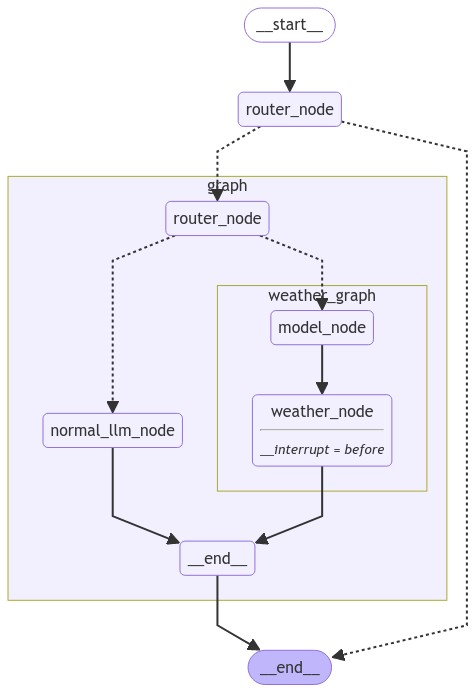

In [25]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(grandparent_graph.get_graph(xray=2).draw_mermaid_png()))

If we run until the interrupt, we can now see that there are snapshots of the state of all three graphs

In [26]:
config = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in grandparent_graph.stream(inputs, config=config, stream_mode="updates", subgraphs=True):
    print(update)

((), {'router_node': {'to_continue': True}})
(('graph:e18ecd45-5dfb-53b0-bcb7-db793924e9a8',), {'router_node': {'route': 'weather'}})
(('graph:e18ecd45-5dfb-53b0-bcb7-db793924e9a8', 'weather_graph:12bd3069-de24-5bc6-b4f1-f39527605781'), {'model_node': {'city': 'San Francisco'}})


In [28]:
state = grandparent_graph.get_state(config, subgraphs=True)
print("Grandparent State:")
print(state.values)
print("---------------")
print("Parent Graph State:")
print(state.tasks[0].state.values)
print("---------------")
print("Subgraph State:")
print(state.tasks[0].state.tasks[0].state.values)

Grandparent State:
{'messages': [HumanMessage(content="what's the weather in sf", id='3bb28060-3d30-49a7-9f84-c90b6ada7848')], 'to_continue': True}
---------------
Parent Graph State:
{'messages': [HumanMessage(content="what's the weather in sf", id='3bb28060-3d30-49a7-9f84-c90b6ada7848')], 'route': 'weather'}
---------------
Subgraph State:
{'messages': [HumanMessage(content="what's the weather in sf", id='3bb28060-3d30-49a7-9f84-c90b6ada7848')], 'city': 'San Francisco'}


We can now continue, acting as the node three levels down

In [29]:
grandparent_graph_state = state
parent_graph_state = grandparent_graph_state.tasks[0].state
subgraph_state = parent_graph_state.tasks[0].state
grandparent_graph.update_state(subgraph_state.config, {"messages": [{"role": "assistant", "content": "rainy"}]}, as_node="weather_node")
for update in grandparent_graph.stream(None, config=config, stream_mode="updates", subgraphs=True):
    print(update)
print(grandparent_graph.get_state(config).values['messages'])

(('graph:e18ecd45-5dfb-53b0-bcb7-db793924e9a8',), {'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", id='3bb28060-3d30-49a7-9f84-c90b6ada7848'), AIMessage(content='rainy', id='be926b59-c647-4355-88fd-a429b9e2b420')]}})
((), {'graph': {'messages': [HumanMessage(content="what's the weather in sf", id='3bb28060-3d30-49a7-9f84-c90b6ada7848'), AIMessage(content='rainy', id='be926b59-c647-4355-88fd-a429b9e2b420')]}})
[HumanMessage(content="what's the weather in sf", id='3bb28060-3d30-49a7-9f84-c90b6ada7848'), AIMessage(content='rainy', id='be926b59-c647-4355-88fd-a429b9e2b420')]


As in the cases above, we can see that the AI responds with "rainy" as we expect.

We can explore the state history to see how the state of the grandparent graph was updated at each step.

In [25]:
for state in grandparent_graph.get_state_history(config):
    print(state)
    print("-----")

StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", id='5ff89e4d-8255-4d23-8b55-01633c112720'), AIMessage(content='rainy', id='7c80f847-248d-4b8f-8238-633ed757b353')], 'to_continue': True}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef66f40-7a2c-6f9e-8002-a37a61b26709'}}, metadata={'source': 'loop', 'writes': {'graph': {'messages': [HumanMessage(content="what's the weather in sf", id='5ff89e4d-8255-4d23-8b55-01633c112720'), AIMessage(content='rainy', id='7c80f847-248d-4b8f-8238-633ed757b353')]}}, 'step': 2, 'parents': {}}, created_at='2024-08-30T17:19:35.793847+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef66f3f-f312-6338-8001-766acddc781e'}}, tasks=())
-----
StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", id='5ff89e4d-8255-4d23-8b55-01633c112720')], 'to_continue': True}, next=('graph',), config={'configurable': {'thr